## **Novelty MNIST**
Here we apply Gaussian-Mixture Models on extracted feature vectors to identify novel samples on the **MNIST** dataset. 

In [1]:
# IMPORTS
# ------------------------
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 
# ------------------------

In [4]:
# CONSTANTS
# ------------------------
BATCH_SIZE = 64
CLASSES = [0, 1]
NOVEL_CLASS = [2]
ALL_CLASSES = [0, 1, 2]
PERC_VAL = 0.20
# ------------------------

Instantiate dataset classes below
------------------------
Seperate data by class -- important for our setting


In [5]:
# func: train_ind( [] ) => []
# return indices matching non-novel classes
def train_ind(dataset, val=False):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in CLASSES:
            indices.append(i)

    # if this is the validation set, return PERC_VAL% of the data      
    if val == True: return indices[:int(PERC_VAL * len(indices))]
    else: return indices[int(PERC_VAL * len(indices)):]
    return indices

# func: test_ind() => []
# return indices matching non-novel classes 
#                         + novel classes
def test_ind(dataset):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in ALL_CLASSES:
            indices.append(i)
    return indices


# Normalize input data...

trainset = torchvision.datasets.MNIST(root='./data', download=True, 
                                     transform=torchvision.transforms.ToTensor())

train_inds = train_ind(trainset)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler = SubsetRandomSampler(train_inds))

val_inds = train_ind(trainset, val=True)
val_loader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler = SubsetRandomSampler(val_inds))

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                     transform=torchvision.transforms.ToTensor())
test_inds = test_ind(testset)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                                         sampler = SubsetRandomSampler(test_inds))

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Select data of two given classes. These will be our non-novel classes.

torch.Size([1, 28, 28])


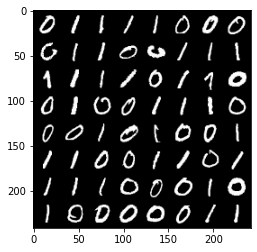

   0  1  2  3  4  5  6  7
0  0  1  1  1  1  0  0  0
1  0  1  1  0  0  1  1  1
2  1  1  1  1  0  1  1  0
3  0  1  0  0  1  1  1  0
4  0  0  1  0  1  0  0  1
5  1  1  0  0  1  1  0  1
6  1  1  1  0  0  0  1  0
7  1  0  0  0  0  0  1  1


In [6]:
# FUNC: imshow( [] ) => None
# SUMMARY: visualize the sampels
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
labels = np.array(labels)
df = pd.DataFrame(labels.reshape( (int(np.sqrt(BATCH_SIZE)), int(np.sqrt(BATCH_SIZE)) )))
print(df)

In [7]:
# util functions
# ---------------
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)


USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

# Constant to control how frequently we print train loss
print_every = 100
print('using device:', device)

using device: cpu


In [8]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()

        self.cn1 = nn.Linear(in_features=in_channel, out_features=channel_1, bias=True)
        nn.init.kaiming_normal_(self.cn1.weight)

        self.cn2 = nn.Linear(in_features=channel_1, out_features=channel_2, bias=True)
        nn.init.kaiming_normal_(self.cn2.weight)

        #self.cn3 = nn.Linear(in_features=channel_2, out_features=channel_3, bias=True)
        #nn.init.kaiming_normal_(self.cn2.weight)

        self.fc = nn.Linear(channel_2, num_classes, bias=True)
        nn.init.kaiming_normal_(self.fc.weight)


    def forward(self, x):
        x = flatten(x)
        scores = None
        # FIRST CONVOLUTIONAL LAYER
        x = self.cn1(x)
        x = F.relu(x)

        # SECOND CONVOLUTIONAL LAYER
        x = self.cn2(x)
        x = F.relu(x)

        # AFFINE FORWARD
        scores = self.fc(x)

        return scores, x
    
    def predict(self, x):
      scores = self.forward(x)
      return scores.argmax(1)

In [9]:
# test the CNN
def test_ThreeLayerConvNet():
    x = torch.zeros((64, 1, 28, 28), dtype=dtype)  # minibatch size 64, image size [28, 28]
    model = ThreeLayerConvNet(in_channel=784, channel_1=4, channel_2=4, num_classes=2)
    scores, _ = model(x)
    print(scores.size())  # you should see [64, 10]

test_ThreeLayerConvNet()

torch.Size([64, 2])


Next, we define the accuracy and training functions

In [10]:
def check_accuracy(loader, model, get_wrong=False):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    wrong_imgs = []
    wrong_labels = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores, _ = model(x)
            _, preds = scores.max(1)

            img_wr = x[preds != y].to('cpu')
            label_wr = preds[preds != y].to('cpu')
            wrong_imgs.extend(img_wr)
            wrong_labels.extend(label_wr)

            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    
    if get_wrong == True: 
      return wrong_imgs, np.array(wrong_labels)

In [9]:
def train(model, optimizer, epochs=5):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores, _ = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(val_loader, model)
                print()
  

In [11]:
learning_rate = 5e-2
channel_1 = 8
channel_2 = 2

input_dims = 784 # 1 channels x 28 by 28 images
model = ThreeLayerConvNet(input_dims, channel_1, channel_2, num_classes=len(CLASSES))

# FOR DEBUGGING
from NovelNetwork import NovelNetwork
from collections import OrderedDict

layers = OrderedDict([
          ('flatten', nn.Flatten()),
          ('lin1', nn.Linear(784, channel_1)),
          ('relu1', nn.ReLU()),
          ('lin2', nn.Linear(channel_1, channel_2)),
          ('relu2', nn.ReLU())
        ])

args = {
  'print_every' : 100,
  'feat_layer'  : 'lin2',
  'feat_sample' : 10,
  'min_g' : 2,
  'max_g' : 10,
  'epoch' : 5,
  'lr' : 5e-2
}
new_model = NovelNetwork(layers)
new_model.train(train_loader, val_loader, args)


Iteration 0, loss = 0.6931
Checking accuracy on validation set
Got 1185 / 2533 correct (46.78)

Iteration 100, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)

Iteration 0, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)

Iteration 100, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)

Iteration 0, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)

Iteration 100, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)

Iteration 0, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)

Iteration 100, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)

Iteration 0, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)

Iteration 100, loss = 0.6931
Checking accuracy on validation set
Got 1192 / 2533 correct (47.06)



KeyError: Flatten(start_dim=1, end_dim=-1)

Test Conventional CNN
------------------------

Verify the above training results with test samples

Checking accuracy on validation set
Got 2531 / 2533 correct (99.92)
Num Wrong:  2
[0 1]


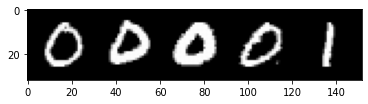

Labels: 0    0    0    0    1    


In [ ]:
wrong_imgs, wrong_preds = check_accuracy(val_loader, model, get_wrong=True)
print('Num Wrong: ', len(wrong_preds))
print(wrong_preds)
# get some random training images
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# show images
img_preds, _ = model(images)
img_preds = (img_preds.to('cpu')).detach().numpy()
labels = (labels.to('cpu')).detach().numpy()

images = images.to('cpu')
imshow(torchvision.utils.make_grid(images[:5]))
print('Labels: ' + ''.join(f'{classes[np.argmax(img_preds[j])]:5s}' for j in range(5)))

Visualize the Failed Instances

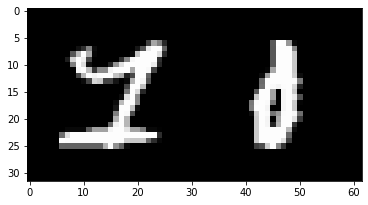

Labels: 0    0    
True Labels: 0    0    


In [ ]:
imshow(torchvision.utils.make_grid(wrong_imgs[:5]))
print('Labels: ' + ''.join(f'{classes[np.argmax(wrong_preds[j])]:5s}' for j in range(len(wrong_preds[:5]))))
print('True Labels: ' + ''.join(f'{classes[np.argmax(labels[j])]:5s}' for j in range(len(wrong_preds[:5]))))



Gaussian Mixture Model
-------------------
Now we'll apply a GaussianMixture to the cluster given the known number of classes (in this case, 2). We can then threshold the distance between any instance and the known class "centers"

In [ ]:
# Get the features from the trainset
# ----------------------------------------
def GMM_batch(is_train=True):
  num_batches = 20
  num_inst = num_batches * BATCH_SIZE

  X_feats = np.array([]).reshape(0, 2)
  X = torch.tensor([])
  y = torch.tensor([])
  for _ in range(0, num_batches):
    if is_train: cur_batch = iter(train_loader)
    else: cur_batch = iter(test_loader) 
    X_batch, y_batch = next(cur_batch)

    X_batch = X_batch.to(device)
    _, cur_feats = model(X_batch)

    X = torch.cat((X.cpu(), X_batch.cpu()), axis=0)
    y = torch.cat((y.cpu(), y_batch.cpu()), axis=0)

    X_feats = np.concatenate((X_feats, cur_feats.detach().cpu()), axis=0)

  return X_feats, X, y
# ----------------------------------------

X_train_feats, X_train, y_train = GMM_batch()
print('Feat Shapes: ', X_train_feats.shape)
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)

Feat Shapes:  (1280, 2)
X_train Shape:  torch.Size([1280, 1, 28, 28])
y_train Shape:  torch.Size([1280])


In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import mahalanobis

# Fit the Gaussian Mixture Model to Extracted Features
# -----------------------------------------------------
gmm_model = GaussianMixture(n_components=len(CLASSES))
gmm_model.fit(X=X_train_feats)

gmm_cov = gmm_model.covariances_
gmm_centers = gmm_model.means_

print('Centers Shape: ', gmm_centers.shape)
print('Cov Shape: ', gmm_cov.shape)
# -----------------------------------------------------


Centers Shape:  (2, 2)
Cov Shape:  (2, 2, 2)


Visualize the Classifications by Plotting 2x2 Cross-Sections

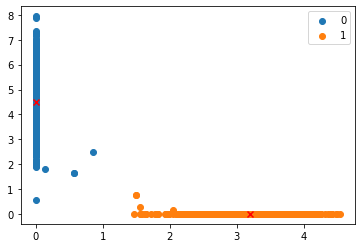

In [ ]:
DIM_1 = 0
DIM_2 = 1

# Get GMM labels
y_pred = gmm_model.predict(X_train_feats)

# Plot Labels (y_pred) using cross-sections of Feature Dimensions (DIM_1, DIM_2)
# -----------------------------------------------------
for i, label in enumerate(CLASSES):
  cur_label = classes[i]
  plt.scatter(X_train_feats[y_pred == i, DIM_1], X_train_feats[y_pred == i, DIM_2], label=cur_label)
plt.scatter(gmm_centers[:, DIM_1], gmm_centers[:, DIM_2], marker='x', color='red')

# -----------------------------------------------------
plt.legend()
plt.show()


Novelty Detection 
---------------------
Use **mahalanobis distance** to threshold points at sufficient standard deviation from the known gaussians.

baseline acc:  0.6921875
gmm acc:  0.6921875


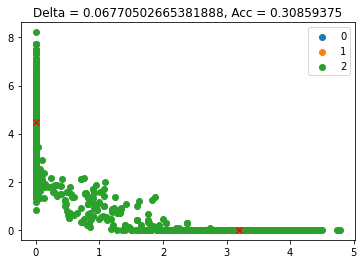

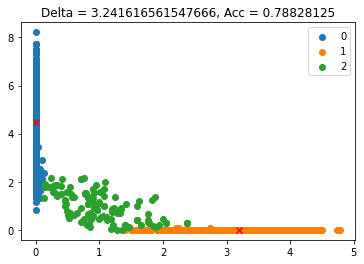

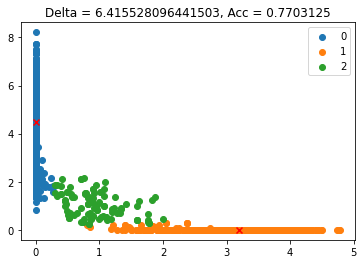

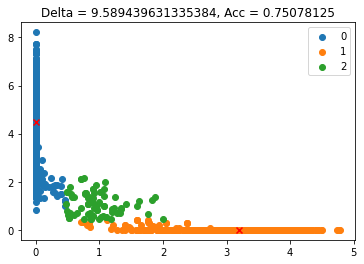

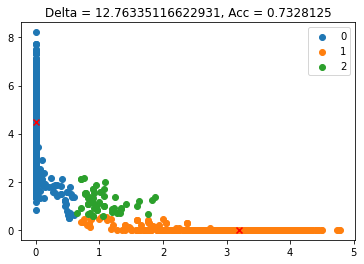

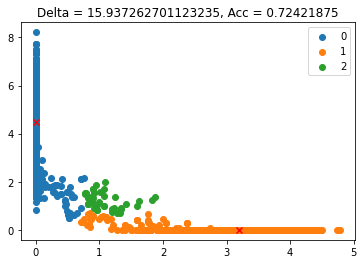

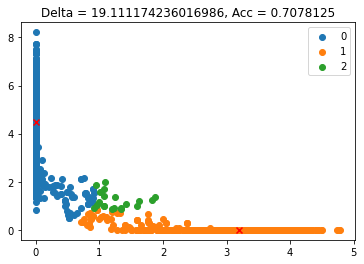

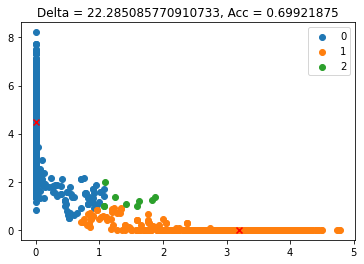

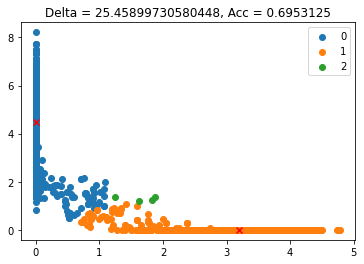

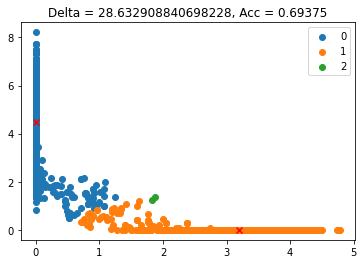

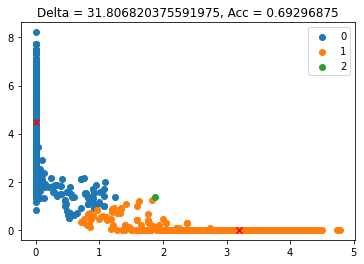

best acc:  0.69296875


In [ ]:
# Extract test data and high-level features
# ----------------------------------------------
X_test_feats, X_test, y_test = GMM_batch(is_train=False)
# ----------------------------------------------


# Get GMM predictions on X_test_feats
# ----------------------------------------------
gmm_preds = gmm_model.predict(X_test_feats)
pred_means = gmm_model.means_[gmm_preds]
# ----------------------------------------------


# Calculate distance between instance and its clsoest center
# ----------------------------------------------
samples_std_distance = np.zeros(shape=X_test_feats.shape[0])
for i, sample in enumerate(X_test_feats):
    cur_sample = sample.reshape(-1, 1)
    cur_mean = pred_means[i].reshape(pred_means[i].shape[0], 1)
    
    iv = np.linalg.inv(gmm_model.covariances_[gmm_preds[i]])
    sample_dist = mahalanobis(cur_sample, cur_mean, iv)
    samples_std_distance[i] = sample_dist
# ----------------------------------------------

# Establish a baseline accuracy (model not trained on novel class '9')
base_preds = np.array((model(X_test.to(device))[0]).cpu().argmax(1))
y_test = np.array(y_test.int())
#print(base_preds)
#print(y_test)

base_acc = np.sum(y_test == base_preds) / len(y_test)
print('baseline acc: ', base_acc)
gmm_acc = np.sum(y_test == gmm_preds) / len(y_test)
print('gmm acc: ', gmm_acc)

# find the best novelty threshold
min_thresh = min(samples_std_distance)
max_thresh = max(samples_std_distance)
threshold = min_thresh
thresh_delta = abs(max_thresh - min_thresh)/1000
cur_it = 0

best_acc = -1
best_threshold = None
while threshold < max_thresh:
  cur_preds = np.array(gmm_preds.copy())
  cur_preds[samples_std_distance > threshold] = NOVEL_CLASS[0]

  cur_acc = np.sum(cur_preds == y_test) / len(y_test)
  if cur_acc > best_acc:
    best_acc = cur_acc
    best_threshold = threshold

  if cur_it % 100 == 0:
    for i, label in enumerate(ALL_CLASSES):
      cur_label = classes[i]
      plt.figure(cur_it)
      plt.scatter(X_test_feats[cur_preds == i, DIM_1], X_test_feats[cur_preds == i, DIM_2], label=cur_label)
    
    plt.scatter(gmm_centers[:, DIM_1], gmm_centers[:, DIM_2], marker='x', color='red')
    plt.title('Delta = {DELTA}, Acc = {ACC}'.format(DELTA=threshold, ACC=cur_acc))
    plt.legend()
    plt.show()

  threshold += thresh_delta
  cur_it = cur_it+1

#print('true labels: ', y_test)
#print('pred labels: ', best_preds)

**Multi-Class** Thresholding
------------------------

Threshold by class rather than a single threshold value

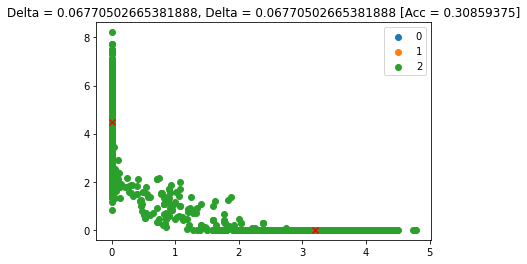

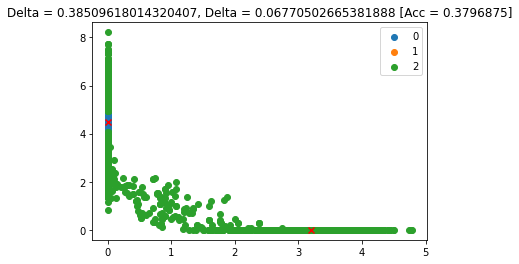

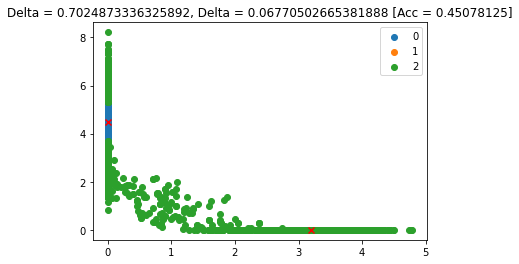

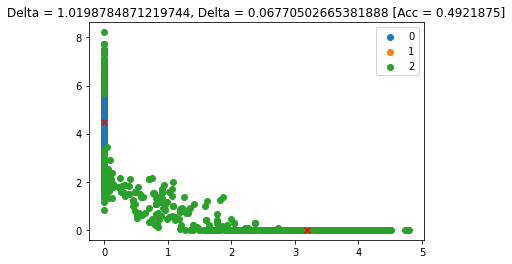

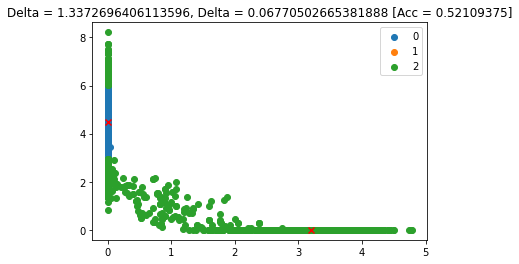

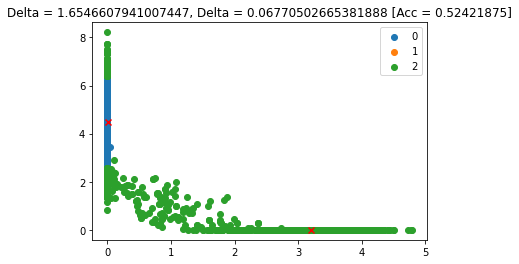

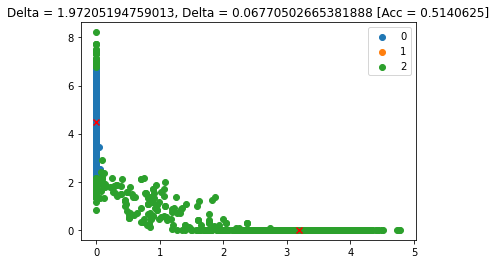

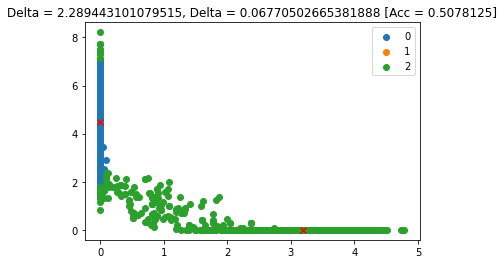

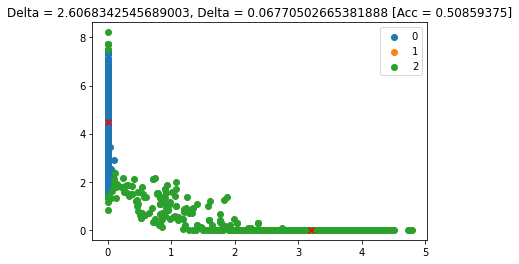

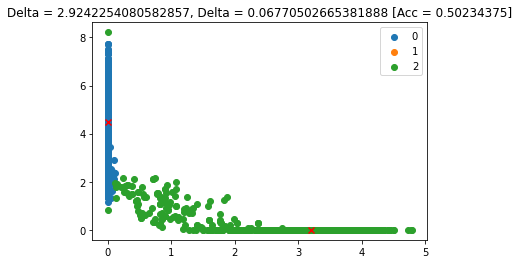

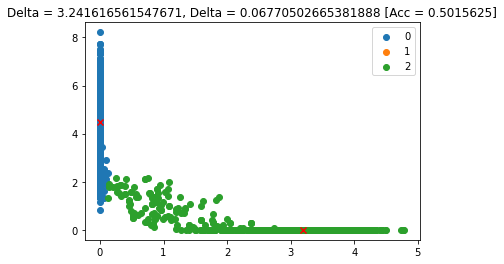

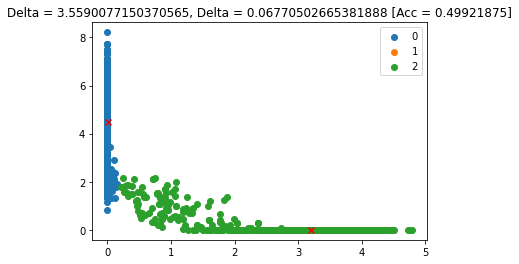

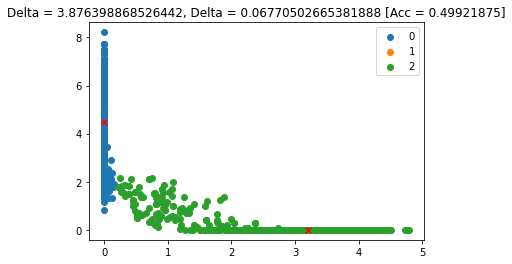

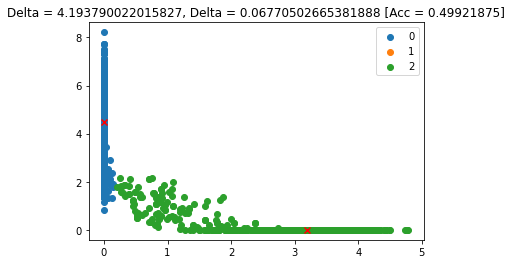

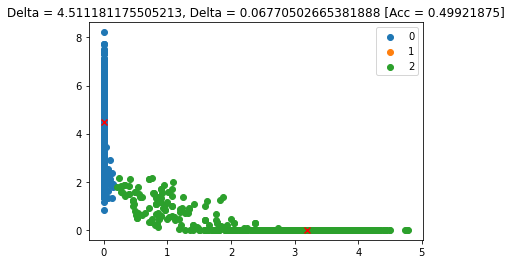

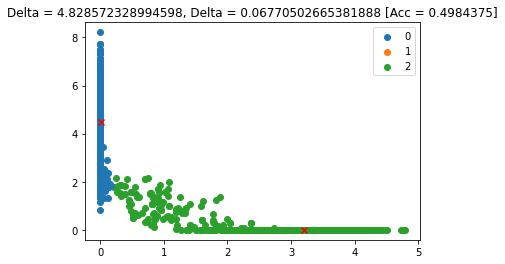

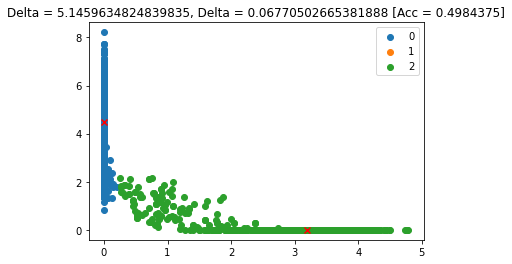

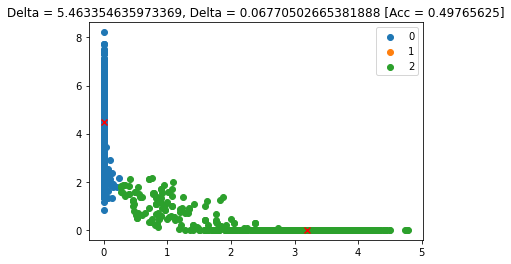

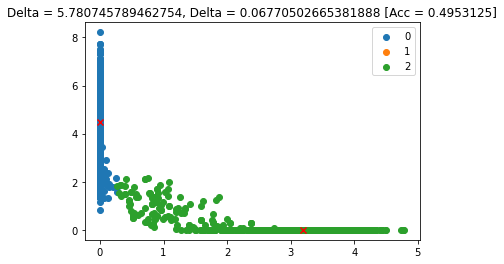

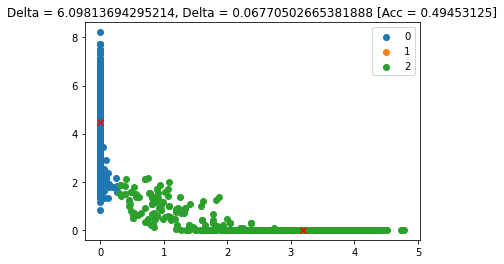

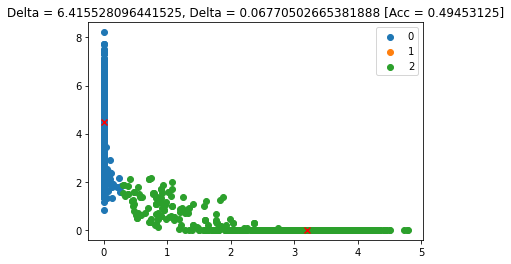

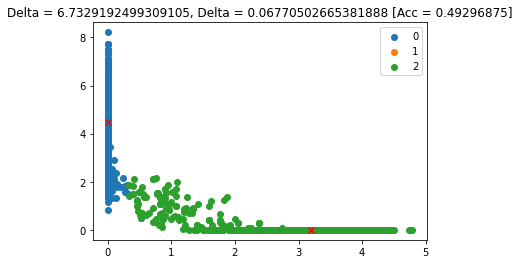

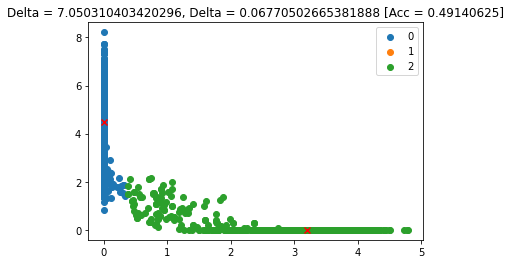

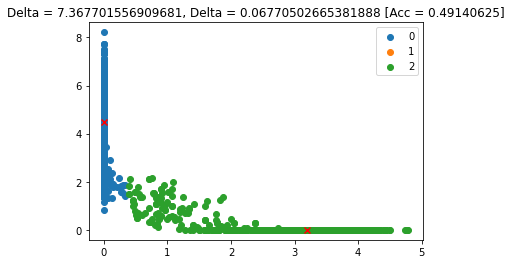

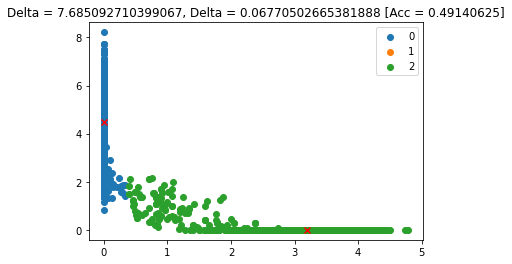

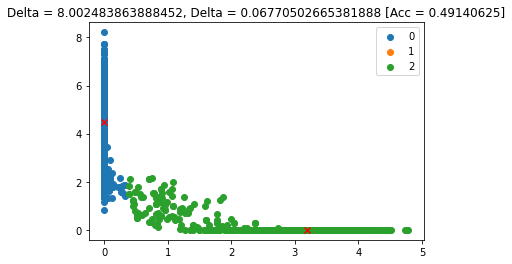

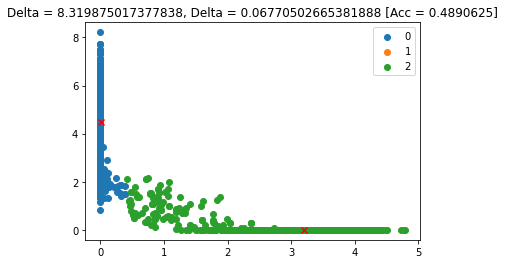

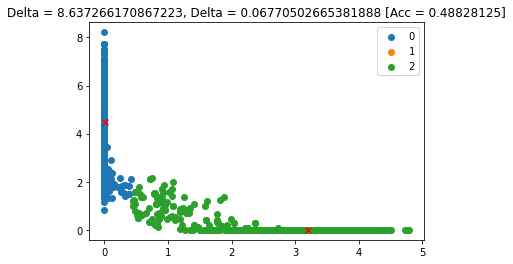

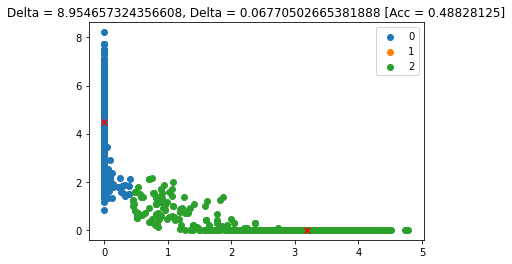

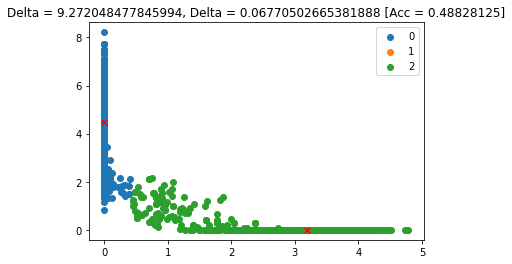

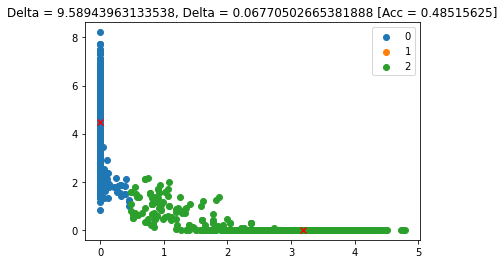

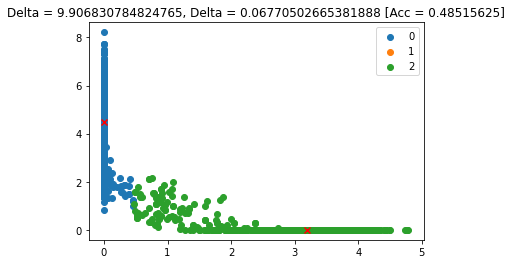

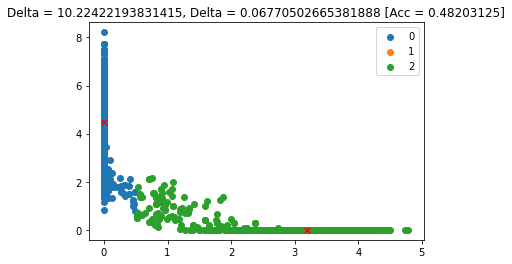

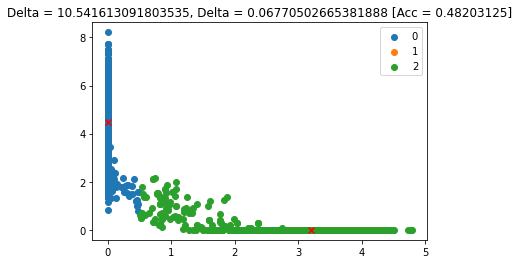

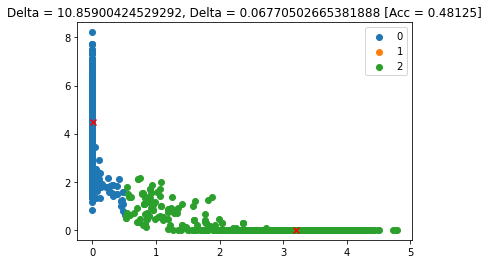

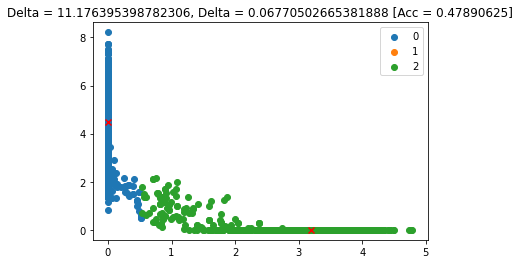

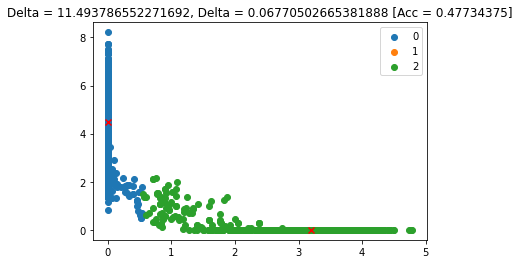

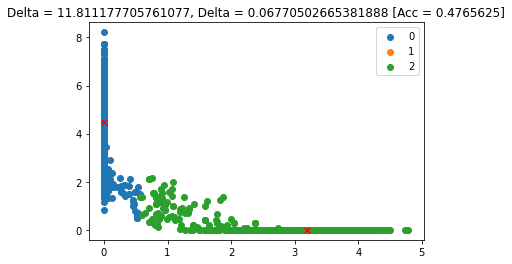

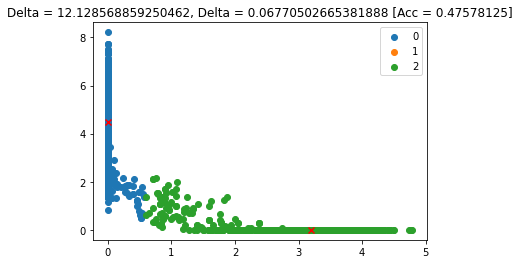

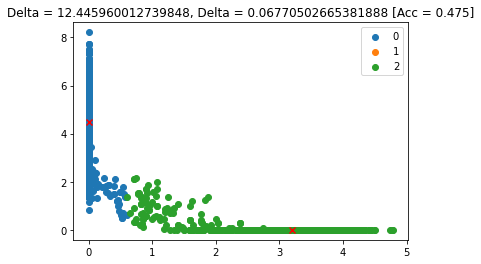

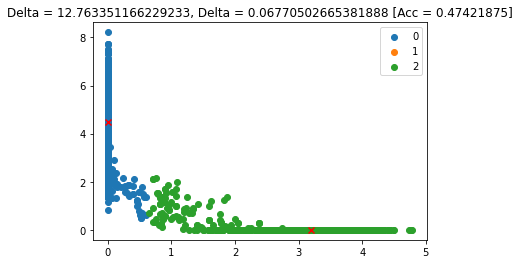

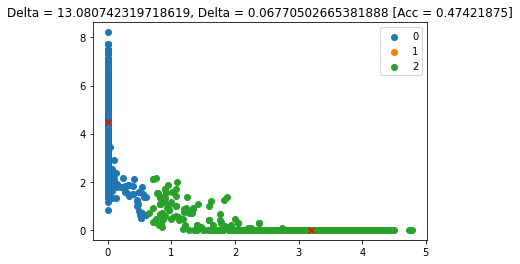

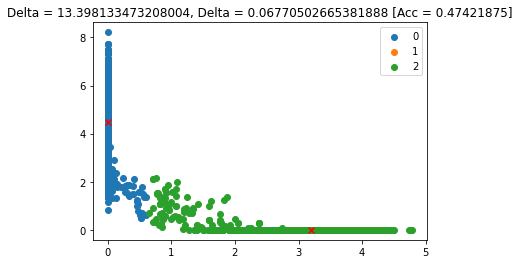

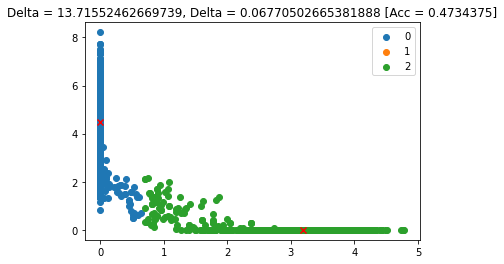

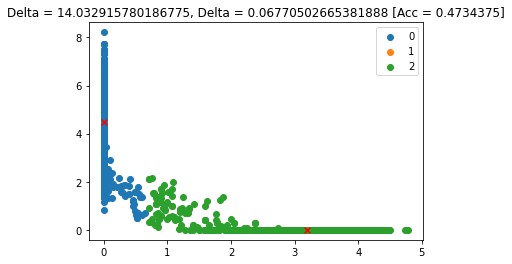

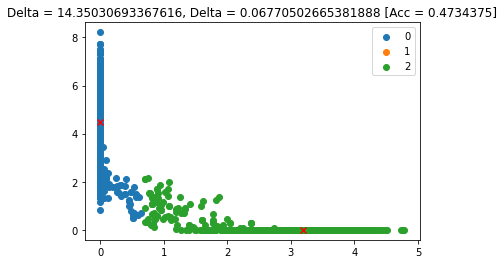

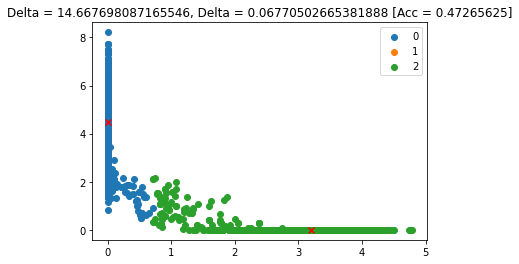

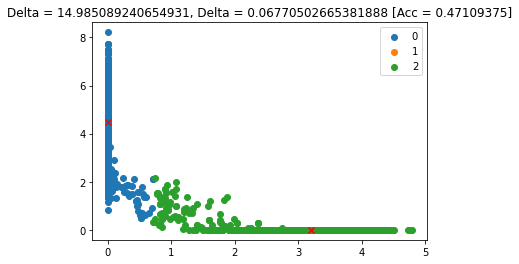

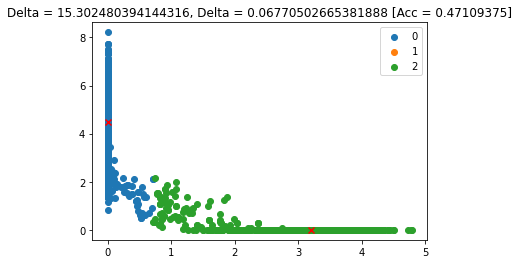

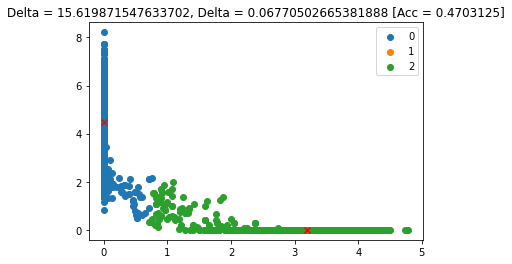

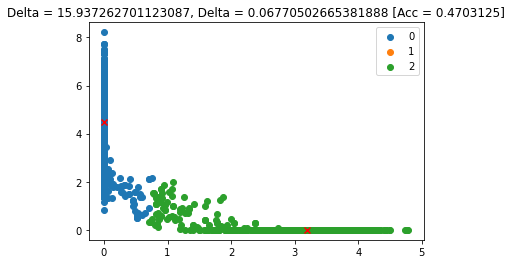

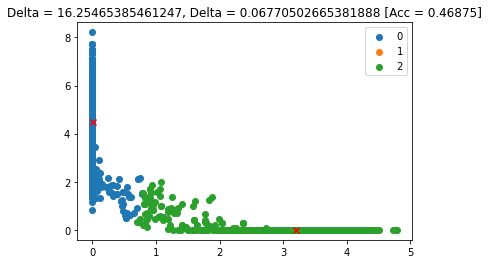

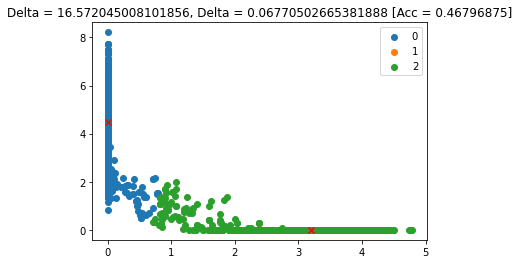

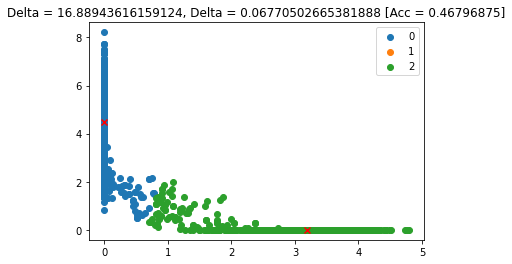

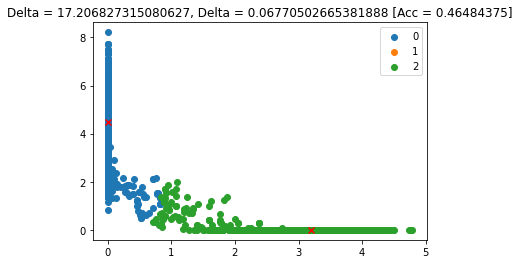

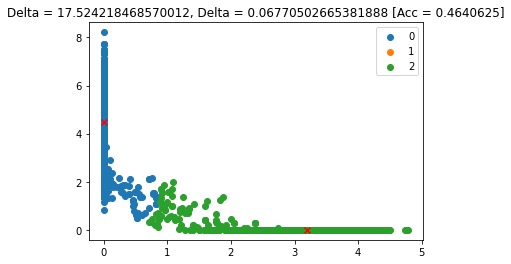

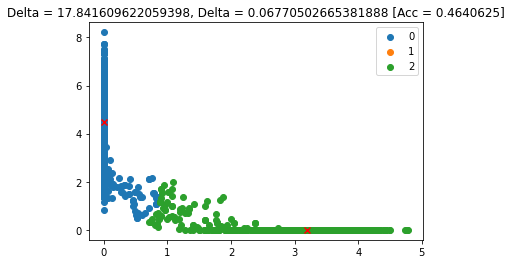

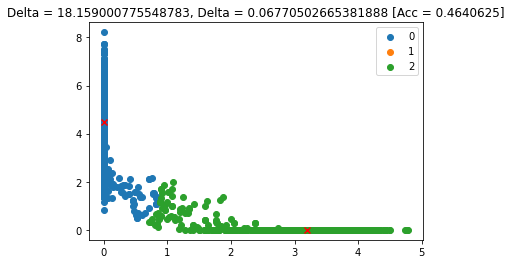

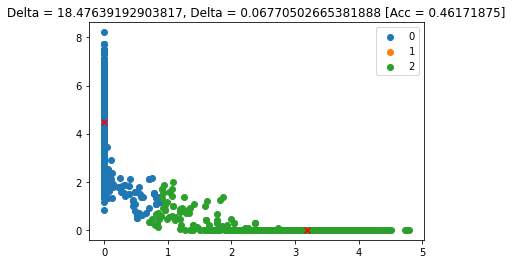

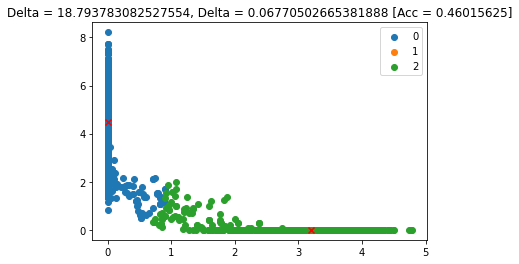

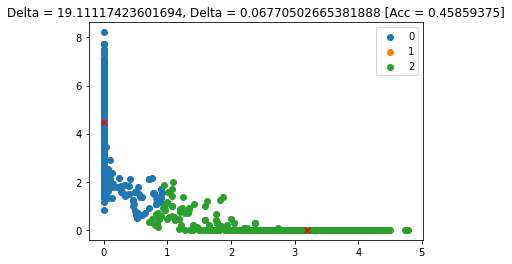

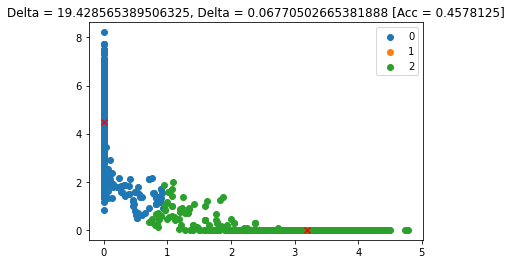

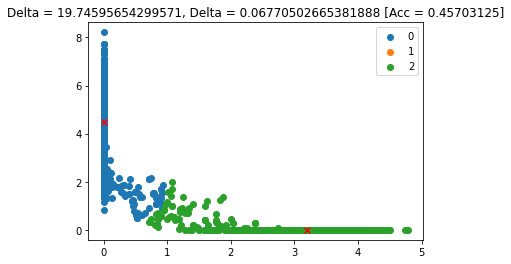

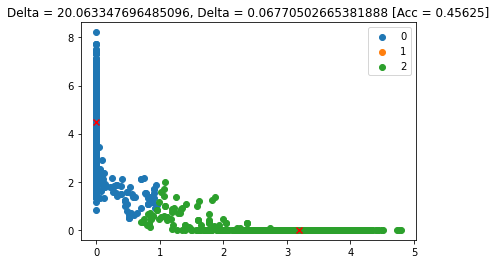

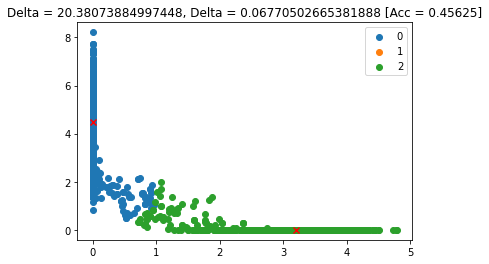

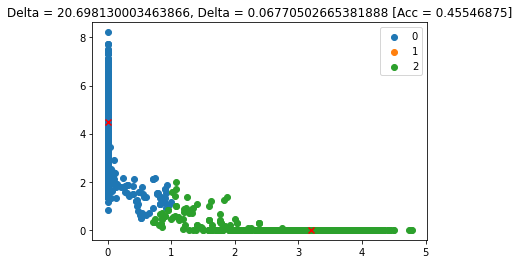

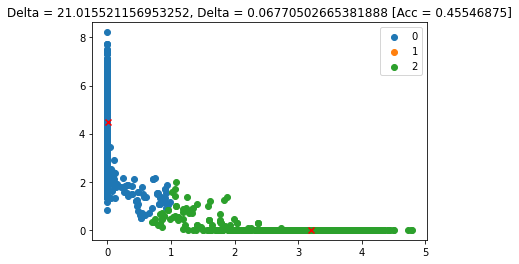

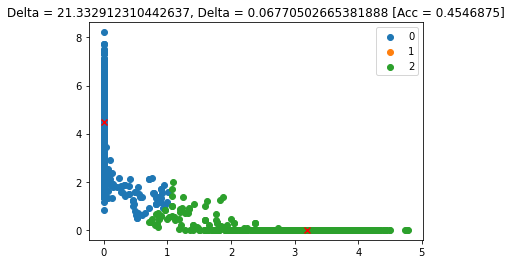

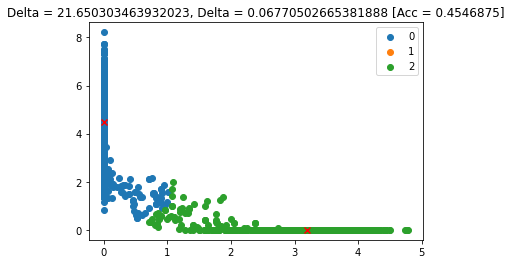

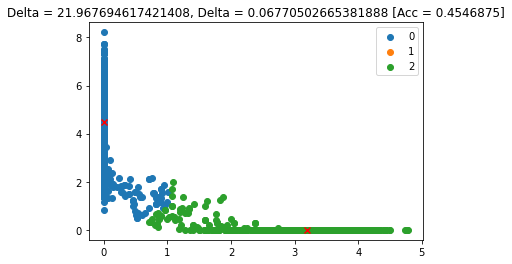

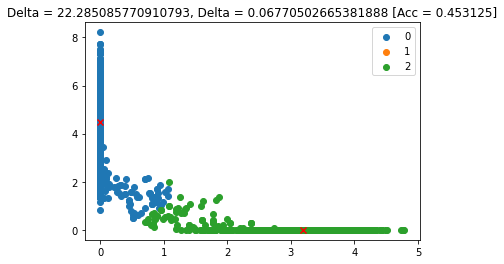

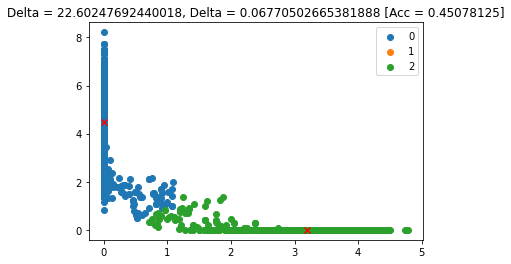

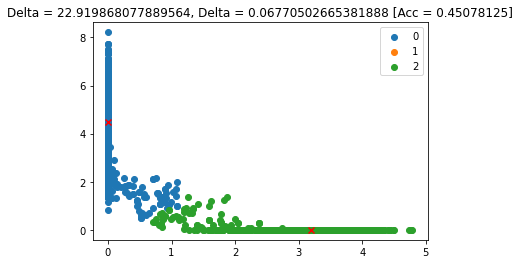

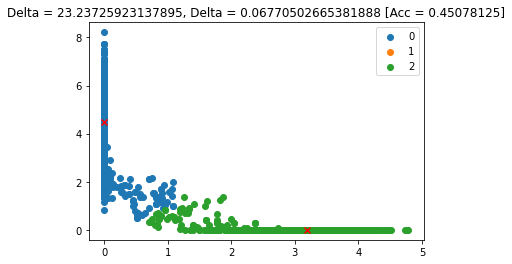

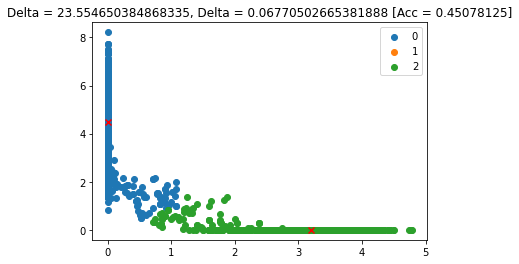

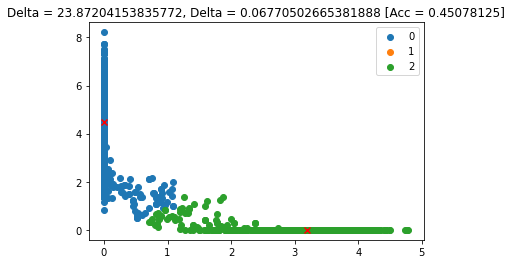

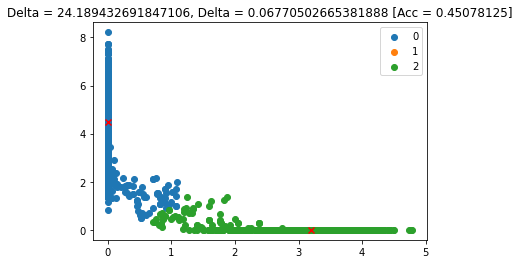

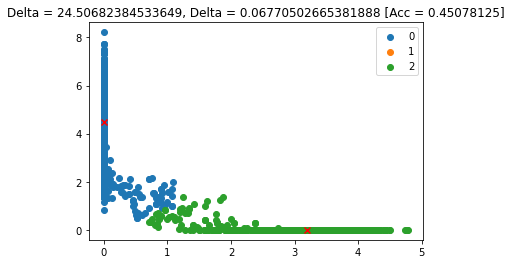

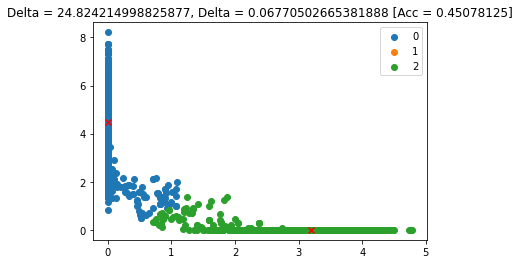

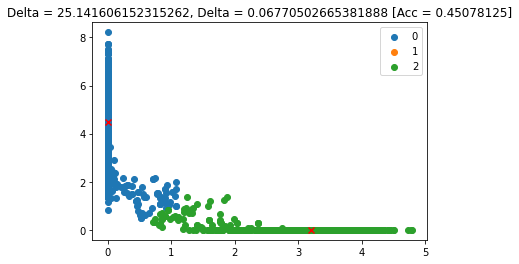

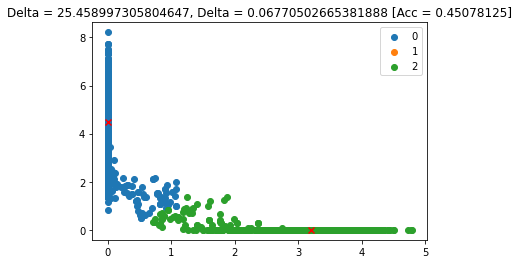

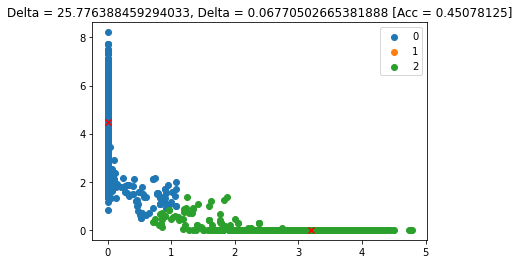

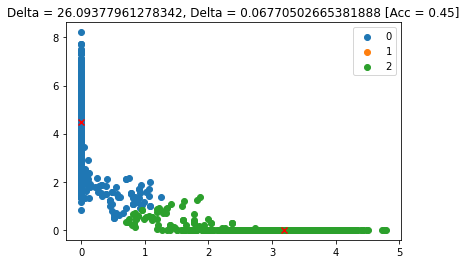

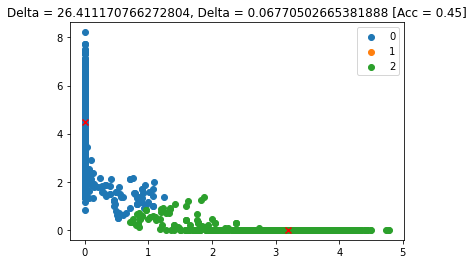

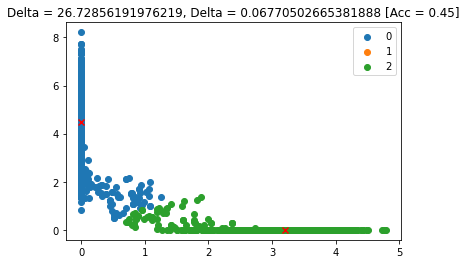

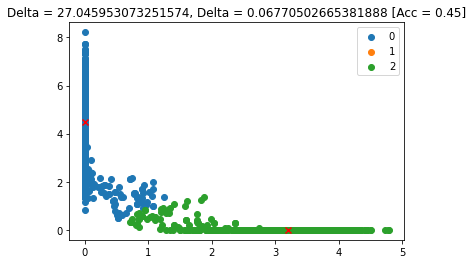

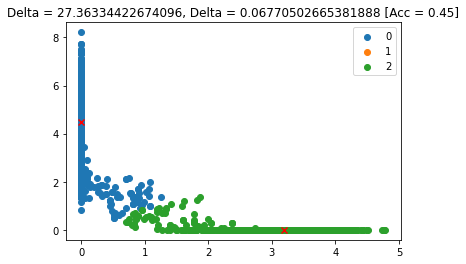

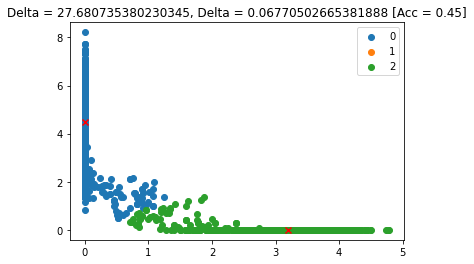

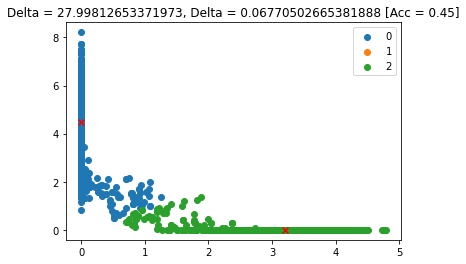

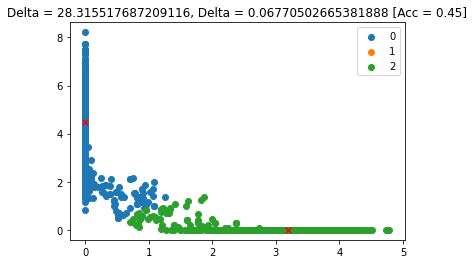

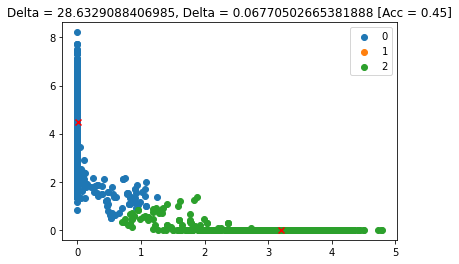

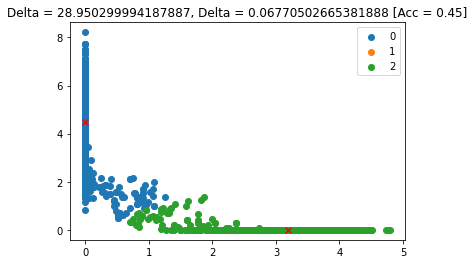

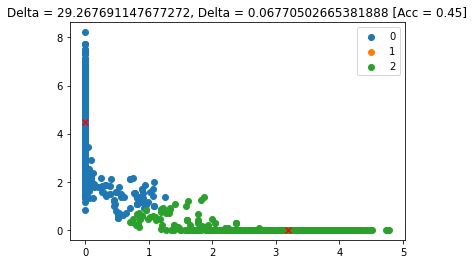

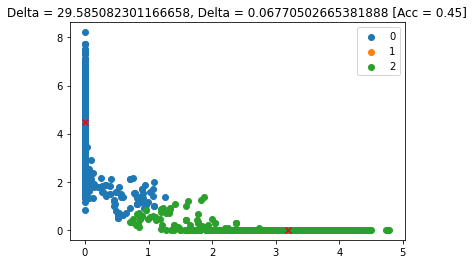

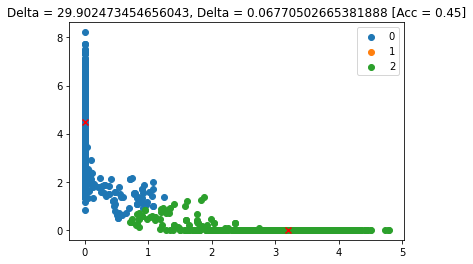

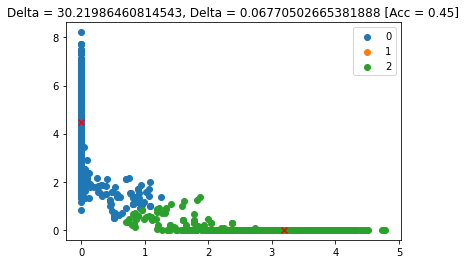

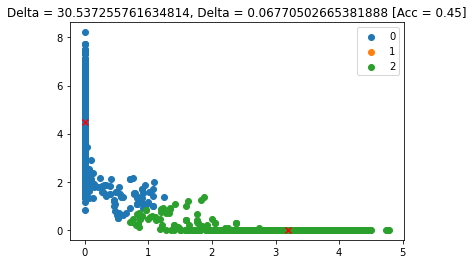

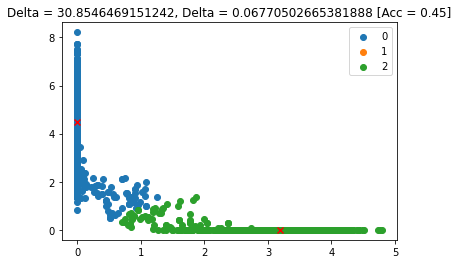

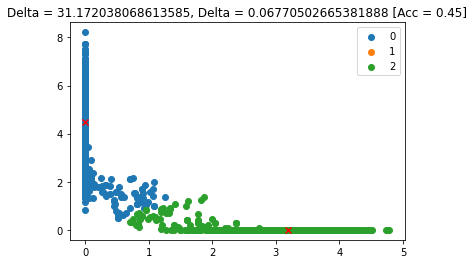

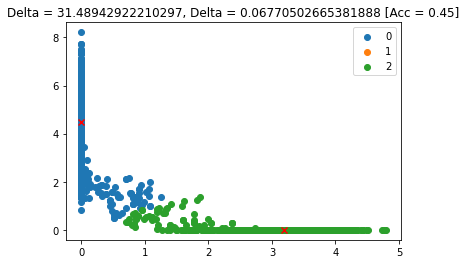

In [ ]:
# thresholds: array holding class threshold scores 
thresholds = np.zeros((len(CLASSES)))

# find the best novelty thresholds
min_thresh = min(samples_std_distance)
max_thresh = max(samples_std_distance)

thresh_delta = abs(max_thresh - min_thresh)/100
cur_it = 0
thresholds[0] = min_thresh
while thresholds[0] < max_thresh:
  thresholds[1] = min_thresh

  while thresholds[1] < max_thresh:
    cur_preds = np.array(gmm_preds.copy())

    #print(cur_it)
    cur_preds[np.where(np.logical_and(samples_std_distance > thresholds[0], cur_preds == 0) )] = NOVEL_CLASS[0]
    cur_preds[np.where(np.logical_and(samples_std_distance > thresholds[1], cur_preds == 1) )] = NOVEL_CLASS[0]

    cur_acc = np.sum(cur_preds == y_test) / len(y_test)

    if cur_it % 100 == 0:
      for i, label in enumerate(ALL_CLASSES):
        cur_label = classes[i]
        plt.figure(cur_it)
        plt.scatter(X_test_feats[cur_preds == i, DIM_1], X_test_feats[cur_preds == i, DIM_2], label=cur_label)
      
      plt.scatter(gmm_centers[:, DIM_1], gmm_centers[:, DIM_2], marker='x', color='red')
      plt.title('Delta = {DELTA1}, Delta = {DELTA2} [Acc = {ACC}]'.format(DELTA1=thresholds[0], DELTA2=thresholds[1], ACC=cur_acc))
      plt.legend()
      plt.show()

    thresholds[1] += thresh_delta
    cur_it = cur_it + 1

  thresholds[0] += thresh_delta
